# Line Characterization

### Imports

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import skew, kurtosis
from scipy.interpolate import interp1d
from model import main, read_data, doppler_shift, plot_spectra, filter_by_theta, get_spectra

% matplotlib inline

In [2]:
plt.rc('text', usetex=True)
plt.rc('font', size=50)

### Mean, Std, Skw

In [7]:
# Functions

def get_stats(data):
    v_th=12.86
    v = -data['x_frec']*v_th
    
    n = len(v)
    
    # mean
    mean = np.sum(v) / n

    # moments m2 (variance), m3, m4
    m2, m3, m4 = 0, 0, 0
    for j in range(n):
        x_j = v[j]
        m2 += (x_j-mean)**2
        m3 += (x_j-mean)**3
        m4 += (x_j-mean)**4
    m2 = m2 / n
    m3 = m3 / n
    m4 = m4 / n

    # std and skw
    std = np.sqrt(m2)
    skw = m3 / (m2**1.5)
    kurt = m4 / (m2**2)
    bi = kurt - skw**2
    
    return mean, std, skw, bi

def plot_stat(vout, logtau, x_scatter, y_scatter, x_plot, y_plot, stat='mn', ylab=False):
    
    dec = 2
    ylabel = '$\mathrm{Mean}$ ($\mathrm{km}$ $\mathrm{s^{-1}}$)'
    if stat == 'std':
        ylabel = '$\mathrm{Standard\;Deviation}$ ($\mathrm{km}$ $\mathrm{s^{-1}}$)'
    elif stat == 'skw':
        ylabel = '$\mathrm{Skewness}$'
    elif stat == 'bi':
        ylabel = '$\mathrm{Bimodality}$'
        
    vout_lab = r'$v_{\mathrm{out}}=$ ' + '${0:.0f}$'.format(vout) + ' $\mathrm{km}$ $\mathrm{s^{-1}}$'
    tau_lab = r'$\tau_{\mathrm{H}}=$ ' + '$10^{0:.0f}$'.format(logtau)
    lab = tau_lab + '\n' + vout_lab
    xlabel = r'$v_{\mathrm{rot}}$  ($\mathrm{km}$ $\mathrm{s^{-1}}$)'
    
    fig = plt.figure(figsize=(10, 10))
    plt.plot(x_plot, y_plot, label='DS', linewidth=6, alpha=0.5, color='black')
    plt.scatter(x_scatter, y_scatter, label='RT', marker='^', color='black', s=600)
    plt.title(lab)
    plt.xlabel(xlabel)
    if ylab:
        plt.ylabel(ylabel)
    ymin = np.min([np.min(y_scatter), np.min(y_plot)])
    ymax = np.max([np.max(y_scatter), np.max(y_plot)])
    plt.xticks([0,50,100])
    plt.yticks(np.around(np.linspace(ymin, ymax, 3), decimals=dec))
    plt.legend(loc='best')
    plt.savefig('./results/line_characterization_'+stat+'_vout'+str(vout)+'_logtau'+str(logtau)+'.pdf', 
                format='pdf', transparent=False, bbox_inches='tight', pad_inches=0.2)
    plt.close()

### Figures: mean_line, standard_deviation, skewness

In [8]:
vrots = [0,50,100]
vrots_doppler = np.linspace(0, 110, 15)
vouts = [5,25,50]
logtaus = [5, 6, 7]

for logtau in logtaus:
    for vout in vouts:
        
        x_rt, x_d = [], []

        y_mn_rt, y_mn_d = [], []
        y_std_rt, y_std_d = [], []
        y_skw_rt, y_skw_d = [], []
        y_bi_rt, y_bi_d = [], []
        
        # radiative transfer
        for vrot in vrots:
            data_rt = read_data(vrot=vrot, vout=vout, logtau=logtau)
            mn, std, skw, bi = get_stats(data_rt)

            x_rt.append(vrot)
            y_mn_rt.append(mn)
            y_std_rt.append(std)
            y_skw_rt.append(skw)
            y_bi_rt.append(bi)
        
        # doppler
        for vrot_d in vrots_doppler:
            data = read_data(vrot=0, vout=vout, logtau=logtau)
            data_doppler = doppler_shift(data, vrot_d)
            
            mn, std, skw, bi = get_stats(data_doppler)
            
            x_d.append(vrot_d)
            y_mn_d.append(mn)
            y_std_d.append(std)
            y_skw_d.append(skw)
            y_bi_d.append(bi)
        
        # write data to compare to muse
        stats = np.array([vrots_doppler, y_std_d, y_skw_d, y_bi_d]).T
        stats_fn = "results/stats_logtau{}_vout{}.txt".format(logtau, vout)
        np.savetxt(stats_fn, stats, fmt='%s') # v_rot, std, skw, bi
        
        ylab = False
        if vout == vouts[0]:
            ylab = True
            
        plot_stat(vout, logtau, x_rt, y_mn_rt, x_d, y_mn_d, stat='mn', ylab=ylab)
        plot_stat(vout, logtau, x_rt, y_std_rt, x_d, y_std_d, stat='std', ylab=ylab)
        plot_stat(vout, logtau, x_rt, y_skw_rt, x_d, y_skw_d, stat='skw', ylab=ylab)
        plot_stat(vout, logtau, x_rt, y_bi_rt, x_d, y_bi_d, stat='bi', ylab=ylab)

### Valley Intensity

In [17]:
# Functions

def get_valley_intensity_ratio(x, y):
    '''
    valley_intensity = y[0]
    
    for i in range(1, len(y)-1):
        past = y[i-1]
        current = y[i]
        future = y[i+1]
        
        if (past>=current and current<=future and current>=valley_intensity):
            valley_intensity = current
    '''
    min_0 = np.where(x<=0)[0][-1]
    max_0 = np.where(x>=0)[0][0]
    
    valley_intensity = (y[min_0] + y[max_0])/2
    y_max = np.max(y)
    
    return valley_intensity/y_max

def plot_valley(vrot, vout, logtau, x_plot, y_plot, x_scatter, y_scatter, ylab=False):        
        
    vrot_lab = r'$v_{\mathrm{rot}}=$ ' + '${0:.0f}$'.format(vrot) + ' $\mathrm{km}$ $\mathrm{s^{-1}}$'    
    vout_lab = r'$v_{\mathrm{out}}=$ ' + '${0:.0f}$'.format(vout) + ' $\mathrm{km}$ $\mathrm{s^{-1}}$'
    tau_lab = r'$\tau_{\mathrm{H}}=$ ' + '$10^{0:.0f}$'.format(logtau)
    xlabel = r'$\cos{\theta}$'
    ylabel = '$\mathrm{Valley/Peak\;Ratio}$'
    
    fig = plt.figure(figsize=(10, 10))
    plt.plot(x_plot, y_plot, label='DS', linewidth=6, alpha=0.5, color='black')
    plt.scatter(x_scatter, y_scatter, label='RT', marker='^', color='black', s=600)
    plt.title(tau_lab + '\n' + vout_lab)
    plt.xlabel(xlabel)
    if ylab:
        plt.ylabel(ylabel)
    ymin = np.min(y_plot)
    ymax = np.max(y_plot)
    plt.xticks([0.0,0.5,1.0])
    #plt.yticks(np.around(np.linspace(ymin, ymax, 3), decimals=2))
    plt.legend(loc='lower left')
    plt.savefig('./results/line_characterization_vi_vout'+str(vout)+'_vrot'+str(vrot)+'_logtau'+str(logtau)+'.pdf', 
                format='pdf', transparent=False, bbox_inches='tight', pad_inches=0.2)
    plt.close()

### Figures: valley_intensity

In [19]:
vrot = 100
vouts = [5, 25, 50]
logtaus = [5, 6, 7]
num_thetas = 9
cos_thetas = np.linspace(0, 1, num_thetas) 

for vout in vouts:
    for logtau in logtaus:

        x_d = []
        y_vi_ds = []
        y_vi_rt = []

        data = read_data(vrot, vout, logtau)

        for i in range(len(cos_thetas)-1):
            cos_theta = cos_thetas[i]
            min_theta = np.arccos(cos_thetas[i+1])
            max_theta = np.arccos(cos_theta)

            #RT
            data_theta = filter_by_theta(data, min_theta, max_theta)
            x_rt, y_rt = get_spectra(data_theta, as_hist=False)

            # DS
            x_ds, y_ds = main(vrot, vout, logtau, min_theta, max_theta)

            x_d.append(cos_theta)
            y_vi_rt.append(get_valley_intensity_ratio(x_rt,y_rt))
            y_vi_ds.append(get_valley_intensity_ratio(x_ds,y_ds))

        ylab = False
        if vout == vouts[0]:
            ylab = True

        plot_valley(vrot, vout, logtau, x_d, y_vi_ds, x_d, y_vi_rt, ylab=ylab)

### Example

In [7]:
vrot = 100
vout = 5
logtau = 7
min_theta = np.arccos(cos_thetas[4])
max_theta = np.arccos(cos_thetas[3])

x, y = main(vrot, vout, logtau, min_theta, max_theta)

In [8]:
np.mean(y), np.std(y), skew(y)

(0.00094114342604881621, 0.00094163003301341193, 0.7296143739077704)

In [9]:
get_valley_intensity_ratio(x,y)

0.088930348258706465

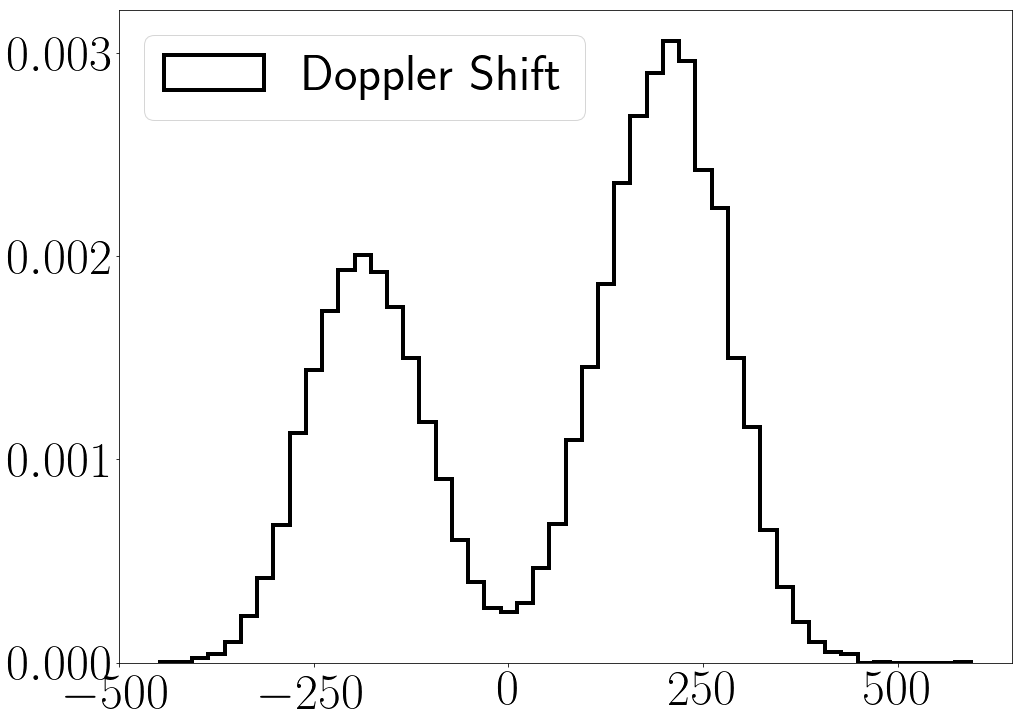

In [12]:
fig, ax = plt.subplots(figsize=(16,12))
plot_spectra(x, y, ax, lw=4, label='Doppler Shift')
plt.legend(loc='upper left')
#plt.axhline(get_valley_intensity(x,y), 0, 1)
plt.show()